In [10]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

plt.style.use([
    'grid',
    'notebook'
])

In [11]:
Ts = 1

sim_time = 1000
iterations = int(sim_time / Ts)

time = np.arange(0, sim_time, Ts)

r = .31
mu = .4
sigma = .55
a4 = .3019

In [12]:
def M1(Z1):
    return 0.0109107652156076*Z1 - 1.36010544163504


def N1(Z2):
    return 0.00454413055105308*Z2 - 0.538288162403591


def P1(Z3):
    return 227.272727272727*Z3 - 0.0909090909090909


def M2(Z1):
    return 1 - M1(Z1)


def N2(Z2):
    return 1 - N1(Z2)


def P2(Z3):
    return 1 - P1(Z3)


pertinence_functions = np.array([
    [M1, M2],
    [N1, N2],
    [P1, P2]
])

In [13]:
diff = 5
h3 = 15
h4 = 10

R34 = (0.2371*diff+6.9192)*10
q0 = (18.6367*h4+700.6831)*1e-4
a3 = (3*r/5)*(2.7*r-((np.cos(2.5*np.pi*(h3-8)*1e-2-mu))/(sigma*np.sqrt(2*np.pi)))*np.exp(-(((h3-8)*1e-2-mu)**2)/(2*sigma**2)))

R34, q0, a3

(81.047, 0.08870501, 0.04425316701733997)

In [14]:
Z1 = 1/R34
Z2 = q0/h4
Z3 = 1/a3

Z1, Z2, Z3

(0.012338519624415463, 0.008870501, 22.59725274821945)

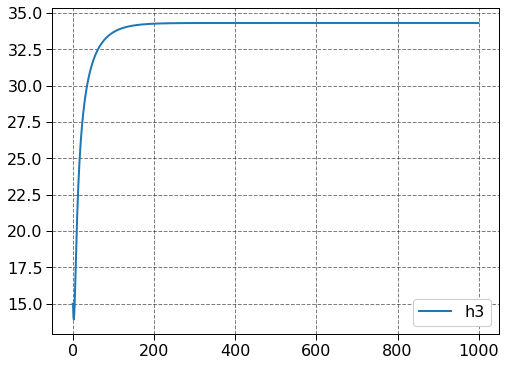

In [18]:
h3_t = np.zeros(iterations)
h4_t = np.zeros(iterations)

h3_0 = 15.
h4_0 = 12.

h3_t[0] = h3_0
h4_t[0] = h4_0

h3 = h3_0
h4 = h4_0

n = 8

A_matrices = [np.load(f'./vertices/A_{i}.npy') for i in range(n)]
B_matrices = [np.load(f'./vertices/B_{i}.npy') for i in range(n)]

u = 47

for i in range(1, iterations):
    diff = h3 - h4

    R34 = (0.2371*diff+6.9192)*10
    q0 = (18.6367*h4+700.6831)*1e-4
    a3 = (3*r/5)*(2.7*r-((np.cos(2.5*np.pi*(h3-8)*1e-2-mu))/(sigma*np.sqrt(2*np.pi)))*np.exp(-(((h3-8)*1e-2-mu)**2)/(2*sigma**2)))

    if h3 < 0:
        h3 = 0
    
    if h4 < 0:
        h4 = 0
    
    h3_t[i] = h3
    h4_t[i] = h4

    h = np.array([
        [h3],
        [h4]
    ])

    Z1 = 1/R34
    Z2 = q0/h4
    Z3 = 1/a3

    v = np.array([
        [pertinence_functions[0, 1](Z1), pertinence_functions[0, 0](Z1)],
        [pertinence_functions[1, 1](Z2), pertinence_functions[1, 0](Z2)],
        [pertinence_functions[2, 1](Z3), pertinence_functions[2, 0](Z3)],
    ])

    weights = np.array([
        v[0, 0] * v[1, 0] * v[2, 0],
        v[0, 0] * v[1, 0] * v[2, 1],
        v[0, 0] * v[1, 1] * v[2, 0],
        v[0, 0] * v[1, 1] * v[2, 1],
        v[0, 1] * v[1, 0] * v[2, 0],
        v[0, 1] * v[1, 0] * v[2, 1],
        v[0, 1] * v[1, 1] * v[2, 0],
        v[0, 1] * v[1, 1] * v[2, 1],
    ])

    Ai = sum([A_matrices[j] * weights[j] for j in range(n)])
    Bi = sum([B_matrices[j] * weights[j] for j in range(n)])

    sys = (Ai@h + Bi*u) * Ts

    h3 += sys[0, 0]
    h4 += sys[1, 0]

plt.plot(time, h3_t, label='h3')
plt.legend()

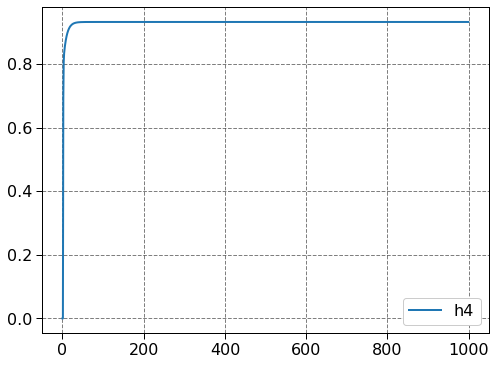

In [ ]:
plt.plot(time, h4_t, label='h4')
plt.legend()